# Assignment 1: CRF sequence tagging for Movie Queries

This coursework involves optimizing the performance of a **Conditional Random Field (CRF) sequence tagger** for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a **BIO (Beginning, Inside, Outside)** tagging format. 

This assignment involves reading in, pre-processing, training and developing your tagger on the training data from *trivia10k13train.bio.txt*, and finally testing your tagger on the data *trivia10k13test.bio.txt*, attempting to get the best performing tagger across the different labels in your development process. Parts of these steps have been done for you already. You are going to optimize the performance of the tagger by improving its feature extraction function on the word sequences, incorporating POS tagging first, then the final exercise is to optimize the performance by all legal means neccessary (except looking at the test data). Run and follow the code below and then attempt the questions.

**NOTEBOOK/CODE SUBMISSION: PLEASE SUBMIT IN NOTEBOOK FORM IF YOU CAN RATHER THAN IN A PYTHON FILE, MAKING YOUR CODE ADDITIONS TO THIS TEMPLATE FILE. SUBMISSION MUST BE IN PYTHON 3.7+ AND YOU MUST HAVE RUN THE CODE RUNNING FROM TOP TO BOTTOM BEFORE SUBMISSION.**

**WRITTEN REPORT SUBMISSION: YOU MUST INCLUDE A 2-PAGE MAX LENGTH REPORT SUMMARIZING HOW YOU WENT ABOUT ACHIEVING EACH QUESTION, TO BE SUBMITTED WITH YOUR CODE. PLEASE WRITE SUCCINCTLY AND CLEARLY, IN THE STYLE OF A SCIENTIFIC NLP CONFERENCE PAPER. AUTOMATIC PLAGIARISM DETECTION WILL BE RUN ON THESE FILES.**

In [2]:
# You may need to run this first- uncomment if so
!pip install python-crfsuite


In [3]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [4]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [5]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [6]:
# have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [7]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

7816 instances
158823 words


In [8]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [9]:
training_data = [preProcess(example) for example in raw_training_data]

In [10]:
# check the effect of pre-processing
print(training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [11]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [12]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [13]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [14]:
# an example from the corpus
example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies"
print_tags(example)

steve       B-Actor
mcqueen     I-Actor
provided    O
a           B-Plot
thrilling   I-Plot
motorcycle  I-Plot
chase       I-Plot
in          I-Plot
this        I-Plot
greatest    I-Plot
of          I-Plot
all         I-Plot
ww          I-Plot
2           I-Plot
prison      I-Plot
escape      I-Plot
movies      I-Plot


In [15]:
# a novel, unseen example we've just made up
print_tags("batman is the main character in batman begins")

batman      O
is          O
the         O
main        O
character   O
in          O
batman      B-Character_Name
begins      I-Character_Name


In [16]:
# another example
print_tags("the sound of music")

the         O
sound       O
of          O
music       O


In [17]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1953 instances
39035 words


In [18]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [19]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.86      0.88      0.87      1274
         B-Award       0.72      0.62      0.67        66
B-Character_Name       0.79      0.24      0.36       283
      B-Director       0.84      0.73      0.78       425
         B-Genre       0.83      0.76      0.79       789
       B-Opinion       0.49      0.30      0.37       195
        B-Origin       0.52      0.38      0.44       190
          B-Plot       0.49      0.47      0.48      1577
         B-Quote       0.75      0.26      0.38        47
  B-Relationship       0.80      0.53      0.64       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.94      0.97      0.96       661
         I-Actor       0.86      0.89      0.87      1553
         I-Award       0.74      0.69      0.72       147
I-Character_Name       0.81      0.29      0.43       227
      I-Director       0.89      0.74      0.81       411
         I-Ge

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.savefig("./test.jpg")
    plt.show() # ta-da!
    

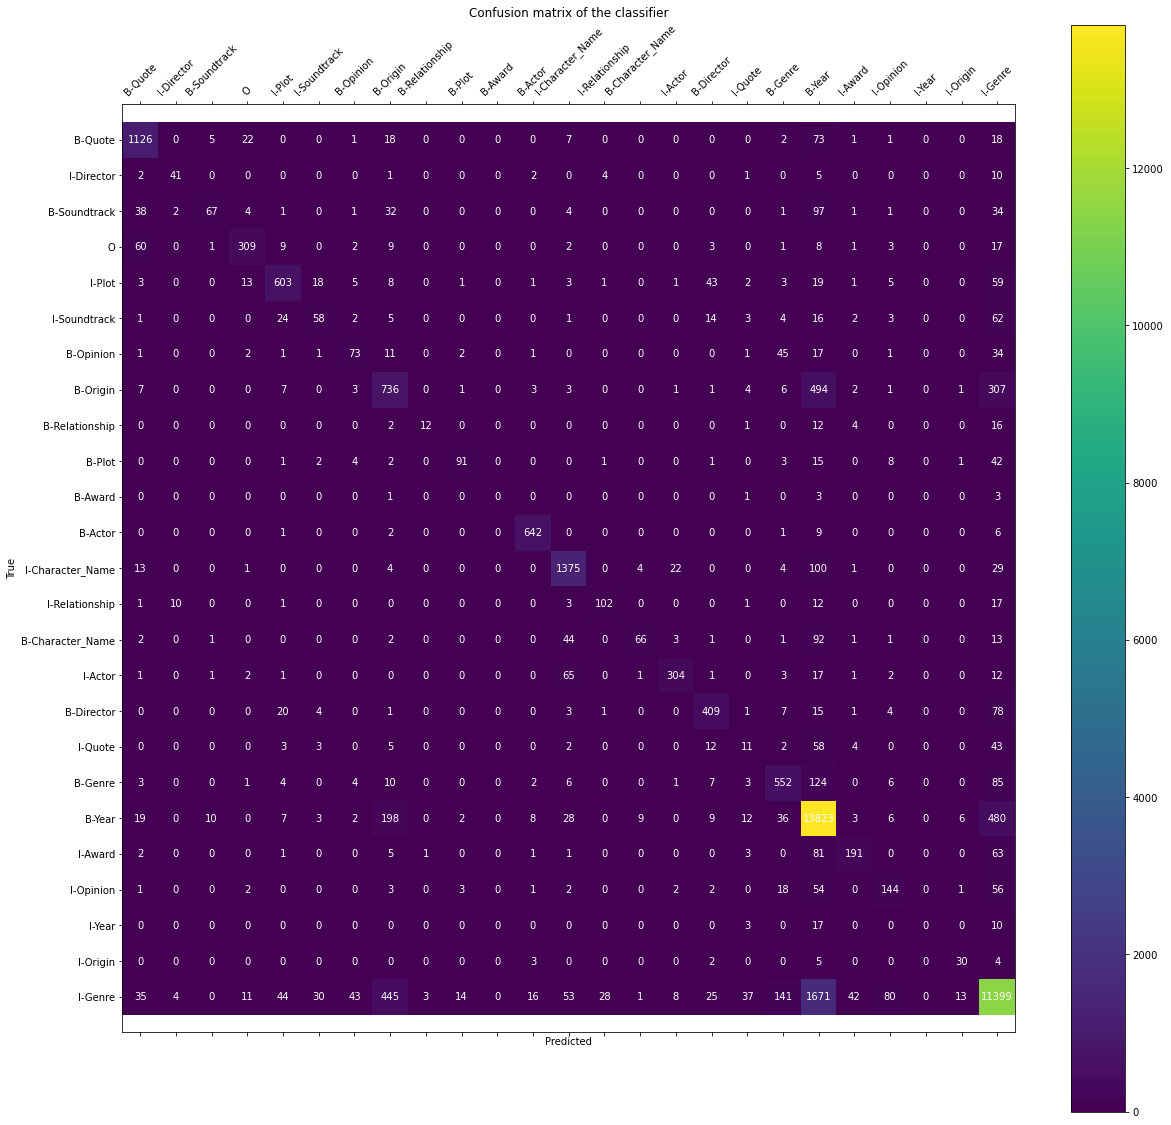

In [21]:
confusion_matrix_heatmap(y_test, preds)

In [22]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [23]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [24]:
print_transition_weights(ct._tagger.info().transitions.items())

8.726939 B-Actor  -> I-Actor
8.342103 B-Plot   -> I-Plot
8.052407 B-Director -> I-Director
7.842415 B-Origin -> I-Origin
7.726710 I-Plot   -> I-Plot
7.555774 I-Quote  -> I-Quote
7.402999 B-Character_Name -> I-Character_Name
7.346180 I-Origin -> I-Origin
7.257884 B-Relationship -> I-Relationship
7.151838 B-Quote  -> I-Quote
7.015753 I-Relationship -> I-Relationship
6.872559 I-Soundtrack -> I-Soundtrack
6.787944 I-Opinion -> I-Opinion
6.738283 B-Genre  -> I-Genre
6.675693 B-Soundtrack -> I-Soundtrack
6.576837 B-Award  -> I-Award
6.441650 B-Opinion -> I-Opinion
6.423250 I-Award  -> I-Award
6.359558 I-Genre  -> I-Genre
6.345432 I-Actor  -> I-Actor
6.223598 I-Character_Name -> I-Character_Name
5.426371 I-Director -> I-Director
4.802900 I-Year   -> I-Year
4.075927 B-Year   -> I-Year
3.776533 B-Character_Name -> B-Plot
3.561809 O        -> O
3.556776 I-Character_Name -> B-Plot
3.275150 O        -> B-Plot
3.196359 B-Plot   -> B-Character_Name
3.081371 B-Opinion -> B-Genre
3.024366 O        -> 

In [25]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [26]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

5.198285 B-Year   HAS_NUM
4.378634 B-Genre  WORD_animated
4.376436 I-Year   WORD_s
3.278435 B-Genre  WORD_thriller
3.001531 B-Quote  WORD_i
2.982563 I-Genre  WORD_animated
2.970617 B-Genre  WORD_action
2.912308 B-Plot   WORD_a
2.909943 B-Opinion WORD_blockbuster
2.682328 B-Award  WORD_oscar
2.664879 B-Genre  WORD_animation
2.592167 B-Relationship SUF_uel
2.571323 B-Director WORD_disney
2.560983 B-Opinion WORD_masterpiece
2.553730 I-Genre  WORD_fiction
2.540611 B-Award  SUF_car
2.522978 B-Relationship WORD_remake
2.487497 B-Actor  WORD_cher
2.441130 B-Genre  WORD_horror
2.431630 I-Genre  WORD_white
2.409133 B-Relationship WORD_sequel
2.405413 I-Genre  WORD_thriller
2.379118 B-Genre  WORD_slasher
2.369672 B-Genre  WORD_comedy
2.340357 B-Origin WORD_adapted
2.302177 I-Actor  WORD_cage
2.279130 B-Genre  WORD_documentary
2.232761 B-Genre  WORD_romance
2.227098 B-Director SUF_xar
2.227098 B-Director WORD_pixar
2.187531 B-Genre  WORD_war
2.178577 B-Award  WORD_won
2.176795 B-Plot   WORD_an
2.

# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.


## The following cell has been added for question 1

In [54]:
from sklearn.model_selection import train_test_split

# with a random state we assure that the train corpus and test corpus have the same data all the time. 
raw_train_corpus, raw_test_corpus = train_test_split(training_data, test_size=0.2, random_state=42)  


In [55]:
print(len(raw_train_corpus), "instances")
print(sum([len(sent) for sent in raw_train_corpus]), "words")

6252 instances
126934 words


In [56]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [57]:
train_corpus = [preProcess(example) for example in raw_train_corpus]

In [58]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list


In [59]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(train_corpus, TAGGER_PATH)
print("done")

training tagger...
done


In [60]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [61]:
# a novel, unseen example we've just made up
example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies"
print_tags(example)

steve       B-Actor
mcqueen     I-Actor
provided    O
a           B-Plot
thrilling   I-Plot
motorcycle  I-Plot
chase       I-Plot
in          I-Plot
this        I-Plot
greatest    I-Plot
of          I-Plot
all         I-Plot
ww          I-Plot
2           I-Plot
prison      I-Plot
escape      I-Plot
movies      I-Plot


In [62]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_corpus = [preProcess(example) for example in raw_test_corpus]
print(len(test_corpus), "instances")
print(sum([len(sent) for sent in test_corpus]), "words")

1564 instances
31889 words


In [63]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_corpus:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    
  
            
print("done")

testing tagger...
done


In [64]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.87      0.88      0.87       967
         B-Award       0.79      0.60      0.68        62
B-Character_Name       0.76      0.24      0.36       217
      B-Director       0.79      0.69      0.73       357
         B-Genre       0.81      0.72      0.76       684
       B-Opinion       0.39      0.27      0.32       165
        B-Origin       0.52      0.33      0.40       157
          B-Plot       0.48      0.44      0.46      1321
         B-Quote       0.22      0.11      0.14        19
  B-Relationship       0.76      0.45      0.56       134
    B-Soundtrack       0.00      0.00      0.00        11
          B-Year       0.96      0.96      0.96       500
         I-Actor       0.87      0.87      0.87      1179
         I-Award       0.72      0.78      0.75       124
I-Character_Name       0.67      0.26      0.37       141
      I-Director       0.83      0.70      0.76       316
         I-Ge

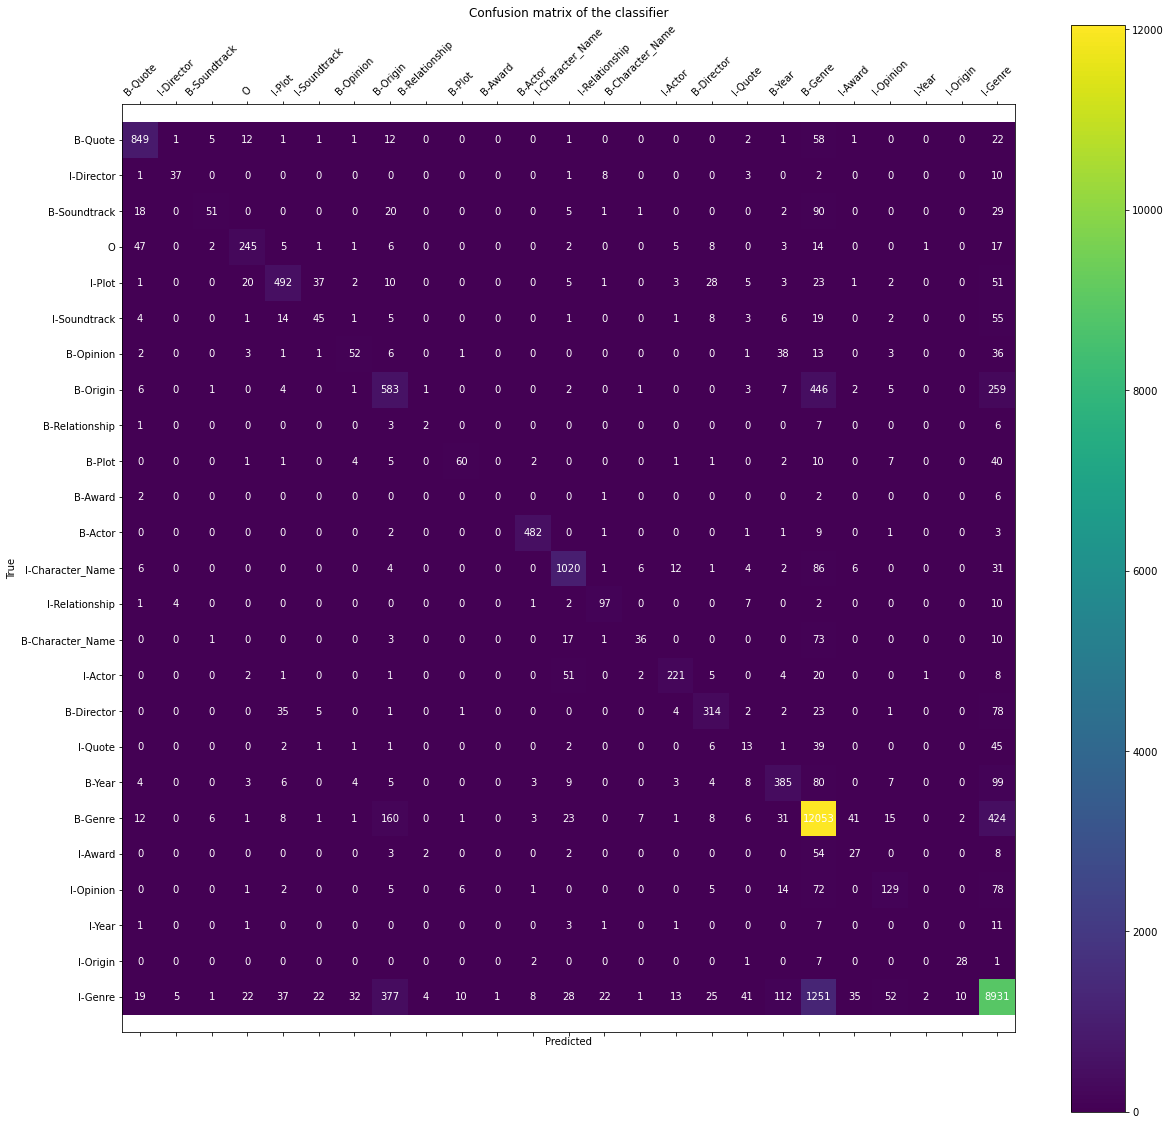

In [65]:
confusion_matrix_heatmap(y_test, preds)

# 2. Error analysis 1: False positives (5 marks)

Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


In [66]:
from sklearn.model_selection import train_test_split

# with a random state we assure that the train corpus and test corpus have the same data all the time. 
raw_train_corpus, raw_test_corpus = train_test_split(training_data, test_size=0.2, random_state=42)  


In [67]:
print(len(raw_train_corpus), "instances")
print(sum([len(sent) for sent in raw_train_corpus]), "words")

6252 instances
126934 words


In [68]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [69]:
train_corpus = [preProcess(example) for example in raw_train_corpus]

In [70]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list


In [71]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(train_corpus, TAGGER_PATH)
print("done")

training tagger...
done


In [72]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [73]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_corpus = [preProcess(example) for example in raw_test_corpus]
print(len(test_corpus), "instances")
print(sum([len(sent) for sent in test_corpus]), "words")


1564 instances
31889 words


## The following cell has been updated for question 2.

In [75]:
categ = ['B-Quote', 'B-Soundtrack', 'I-Opinion', 'I-Quote', 'I-Soundtrack']  


print("testing tagger...")
preds = []
y_test = []
for sent in test_corpus:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
      
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    
    #For each sentence it will check if each of the predictions corresponds to a tag inside the categ array. If it does, and its class does not match with the ground truth --> false positive.
    for i in range (len(sent_preds)): 
        if sent_preds[i] not in categ:
            continue; 
        if sent_preds[i] == sent_true[i]:
            continue; 
        else: 

            print("**** FALSE POSITIVE****\n\n"+'\033[1m' +"{" + sent[i][0].title() + "}" +'\033[0m'+ " in position " + str(i) + " was classified as "+ sent_preds[i]+ " but the ground truth label is "+sent_true[i]+"\n")
            print(sent)
            print('*'*50)
            print()
        
print("done")

testing tagger...
**** FALSE POSITIVE****

{How} in position 12 was classified as B-Quote but the ground truth label is B-Plot

[('what', 'O'), ('is', 'O'), ('the', 'O'), ('name', 'O'), ('of', 'O'), ('the', 'O'), ('fifth', 'B-Relationship'), ('movie', 'I-Relationship'), ('in', 'O'), ('the', 'O'), ('series', 'O'), ('about', 'O'), ('how', 'B-Plot'), ('you', 'I-Plot'), ('ca', 'I-Plot'), ('n', 'I-Plot'), ('t', 'I-Plot'), ('cheat', 'I-Plot'), ('death', 'I-Plot'), ('or', 'I-Plot'), ('fate', 'I-Plot')]
**************************************************

**** FALSE POSITIVE****

{You} in position 13 was classified as I-Quote but the ground truth label is I-Plot

[('what', 'O'), ('is', 'O'), ('the', 'O'), ('name', 'O'), ('of', 'O'), ('the', 'O'), ('fifth', 'B-Relationship'), ('movie', 'I-Relationship'), ('in', 'O'), ('the', 'O'), ('series', 'O'), ('about', 'O'), ('how', 'B-Plot'), ('you', 'I-Plot'), ('ca', 'I-Plot'), ('n', 'I-Plot'), ('t', 'I-Plot'), ('cheat', 'I-Plot'), ('death', 'I-Plot'), ('

# 3. Error analysis 2: False negatives (5 marks)

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


In [76]:
from sklearn.model_selection import train_test_split

# with a random state we assure that the train corpus and test corpus have the same data all the time. 
raw_train_corpus, raw_test_corpus = train_test_split(training_data, test_size=0.2, random_state=42)  


In [78]:
print(len(raw_train_corpus), "instances")
print(sum([len(sent) for sent in raw_train_corpus]), "words")

6252 instances
126934 words


In [79]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [80]:
train_corpus = [preProcess(example) for example in raw_train_corpus]

In [81]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list


In [82]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(train_corpus, TAGGER_PATH)
print("done")

training tagger...
done


In [83]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [84]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_corpus = [preProcess(example) for example in raw_test_corpus]
print(len(test_corpus), "instances")
print(sum([len(sent) for sent in test_corpus]), "words")


1564 instances
31889 words


## The following cell has been updated for question 3.

In [86]:
categ = ['B-Quote', 'B-Soundtrack', 'I-Opinion', 'I-Character_Name', 'I-Soundtrack']  


print("testing tagger...")
preds = []
y_test = []
for sent in test_corpus:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
      
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    
     #For each sentence it will check if each of the ground truth labels corresponds to a tag inside the categ array. 
     #If it does, and its class does not match with the predictions --> false negative.
   
    for i in range (len(sent_preds)): 
        if sent_true[i] not in categ:
            continue; 
        if sent_preds[i] == sent_true[i]:
            continue; 
        else: 
            print("**** FALSE NEGATIVE****\n\n"+'\033[1m' +"{" + sent[i][0].title() + "}" +'\033[0m'+ " in position " + str(i) + " was classified as "+ sent_preds[i]+ " but the ground truth label is "+sent_true[i]+"\n")
            print(sent)
            print('*'*50)
            print()
            
        
print("done")

testing tagger...
**** FALSE NEGATIVE****

{A} in position 0 was classified as B-Plot but the ground truth label is B-Quote

[('a', 'B-Quote'), ('clue', 'I-Quote'), ('a', 'I-Quote'), ('clue', 'I-Quote'), ('my', 'I-Quote'), ('kingdom', 'I-Quote'), ('for', 'I-Quote'), ('a', 'I-Quote'), ('clue', 'I-Quote'), ('about', 'O'), ('which', 'O'), ('movie', 'O'), ('i', 'O'), ('m', 'O'), ('asking', 'O'), ('about', 'O')]
**************************************************

**** FALSE NEGATIVE****

{Stark} in position 8 was classified as I-Plot but the ground truth label is I-Character_Name

[('what', 'O'), ('2010', 'B-Year'), ('movie', 'O'), ('finds', 'O'), ('superhero', 'B-Plot'), ('alter', 'I-Plot'), ('ego', 'I-Plot'), ('tony', 'B-Character_Name'), ('stark', 'I-Character_Name'), ('once', 'B-Plot'), ('again', 'I-Plot'), ('battling', 'I-Plot'), ('evil', 'I-Plot'), ('and', 'I-Plot'), ('saving', 'I-Plot'), ('the', 'I-Plot'), ('day', 'I-Plot')]
**************************************************

**** FA

# 4. Incorporating POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

In [87]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(posttagger.tag(words))

[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


In [88]:
from sklearn.model_selection import train_test_split

# with a random state we assure that the train corpus and test corpus have the same data all the time. 
raw_train_corpus, raw_test_corpus = train_test_split(training_data, test_size=0.2, random_state=42)  


In [89]:
print(len(raw_train_corpus), "instances")
print(sum([len(sent) for sent in raw_train_corpus]), "words")

6252 instances
126934 words


## The following cell has been updated for question 4.

In [94]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""
    
    #CRFTagger is used to add the POS tag of each token.
    posttagger = CRFTagger()
    posttagger.set_model_file("crf_pos.tagger")
    train_corpusPOS=[]
   
    #The function takes a list of (word, biotag). An array for words and other for biotags are used for future use. 
    words=[]
    biotag=[]
    for i in range(len(example)):
        words.append(example[i][0])
        biotag.append(example[i][1]) 
            
    #Each words is POS tagged. 
    tagger=posttagger.tag(words)

    #Concatenate the word and the POS tag with @. After, create a tuple that includes the concatenated new word and the biotag. 
    for tupple, bT in zip(tagger, biotag):
        POSWord=('{0}@{1}'.format(tupple[0],''.join(tupple[1])))
        line=(POSWord, bT)
        train_corpusPOS.append(line)
    


    preprocessed_example = train_corpusPOS  
    return preprocessed_example

In [95]:
train_corpus = [preProcess(example) for example in raw_train_corpus]

In [96]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    raw_token = tokens[idx]
    
    token =raw_token.split("@")[0]
    tag =raw_token.split("@")[1]
  
    
    
    feature_list = []
    
    feature_list.append("TAG_"+tag)
    
    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    
    #feature_list.append("CONTEXT_" + context_token)
    #print(feature_list)
    return feature_list


In [97]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(train_corpus, TAGGER_PATH)
print("done")

training tagger...
done


In [98]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [99]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_corpus = [preProcess(example) for example in raw_test_corpus]
print(len(test_corpus), "instances")
print(sum([len(sent) for sent in test_corpus]), "words")

1564 instances
31889 words


In [100]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_corpus:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    
    
print("done")

testing tagger...
done


In [101]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.86      0.89      0.88       967
         B-Award       0.81      0.61      0.70        62
B-Character_Name       0.68      0.24      0.35       217
      B-Director       0.79      0.70      0.74       357
         B-Genre       0.82      0.72      0.77       684
       B-Opinion       0.43      0.31      0.36       165
        B-Origin       0.51      0.34      0.41       157
          B-Plot       0.49      0.45      0.47      1321
         B-Quote       0.40      0.21      0.28        19
  B-Relationship       0.75      0.46      0.57       134
    B-Soundtrack       0.00      0.00      0.00        11
          B-Year       0.96      0.97      0.96       500
         I-Actor       0.86      0.90      0.88      1179
         I-Award       0.75      0.79      0.77       124
I-Character_Name       0.61      0.31      0.41       141
      I-Director       0.83      0.72      0.77       316
         I-Ge

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


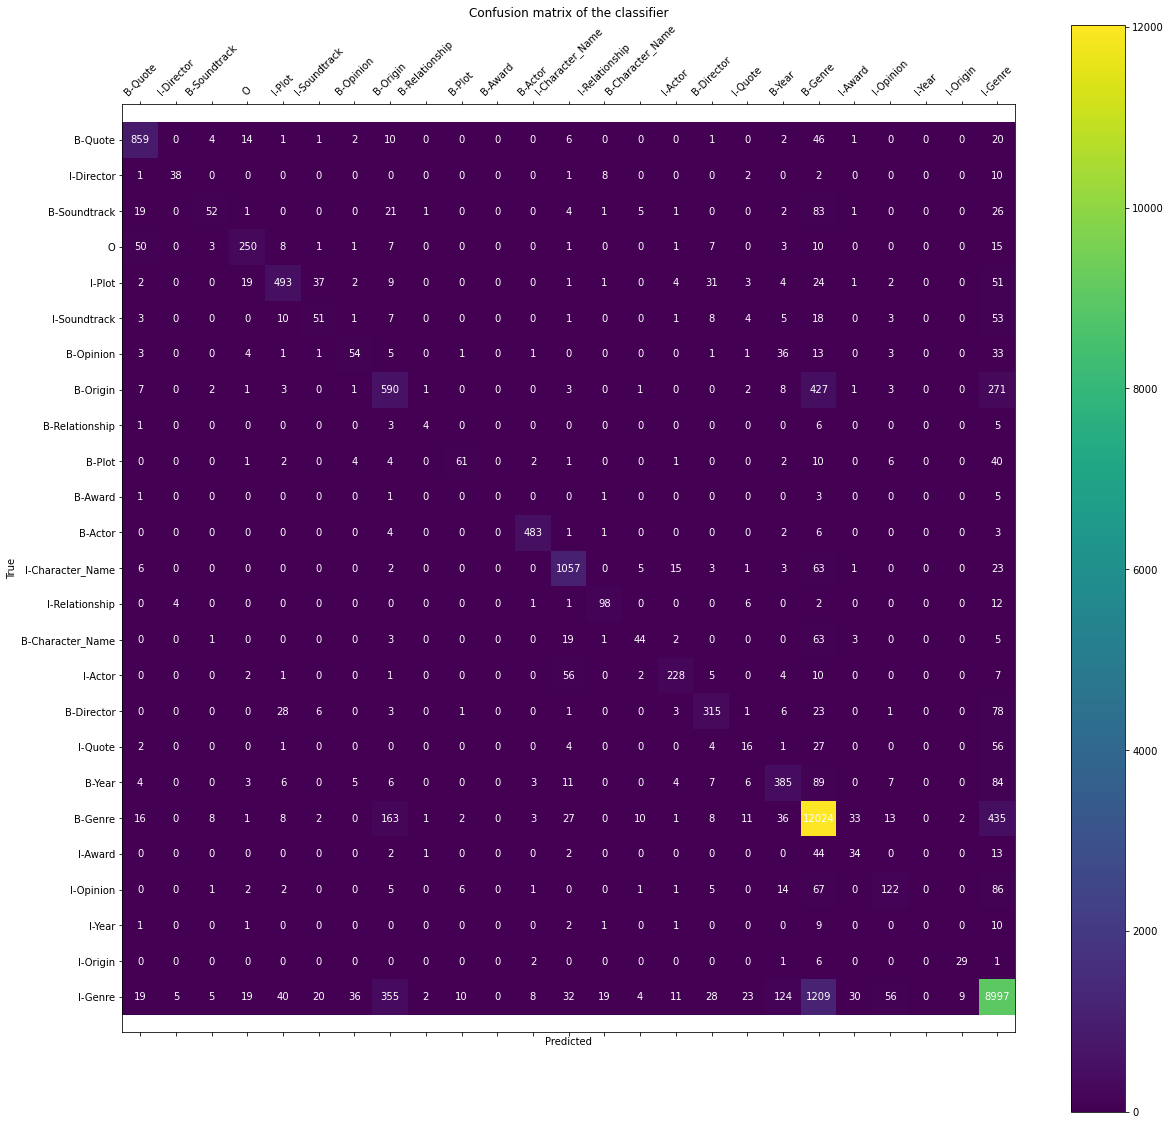

In [102]:
confusion_matrix_heatmap(y_test, preds)

# 5. Feature experimentation and other optimization for optimal macro average (30 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format and make sure you describe this in your report.

Feature tips: You could try more suffixes/prefixes of the current word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q2 and Q3 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes.

Model tips: After your feature engineering, for even better performance you could try optimizing the hyperparameters by adjusting the `training_opt` dictionary values, experimenting with changing the minimum document frequency, c1 and c2 regularization parameters for https://www.nltk.org/api/nltk.tag.crf.html#nltk.tag.crf.CRFTagger.__init__ e.g. changing the initialization to make the minimum feature frequency 2 (rather than the default 1) would be:

`ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":2})`

Leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. from the test file `trivia10k13train.bio.txt`) as your final piece of code.

In [101]:
from sklearn.model_selection import train_test_split

# with a random state we assure that the train corpus and test corpus have the same data all the time. 
raw_train_corpus, raw_test_corpus = train_test_split(training_data, test_size=0.2, random_state=42)  


In [102]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""
    
    posttagger = CRFTagger()
    posttagger.set_model_file("crf_pos.tagger")
    train_corpusPOS=[]
   
    words=[]
    biotag=[]
    for i in range(len(example)):
        words.append(example[i][0])
        biotag.append(example[i][1]) 
            
    tagger=posttagger.tag(words)

    for tupple, bT in zip(tagger, biotag):
        POSWord=('{0}@{1}'.format(tupple[0],''.join(tupple[1])))
        line=(POSWord, bT)
        train_corpusPOS.append(line)
   


    preprocessed_example = train_corpusPOS  # trivial- no preprocessing
    return preprocessed_example

In [103]:
train_corpus = [preProcess(example) for example in raw_train_corpus]

## The folloing cell has been updated for question 5.

In [104]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

#Libraries for stemming.
from nltk.stem import PorterStemmer
pst = PorterStemmer()

#Libraries for lemmatizing.
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    
    
    
    raw_token = tokens[idx]
    
    #Split the token from its POStag and add each one as a feature. 
    token =raw_token.split("@")[0]
    tag = raw_token.split("@")[1]
    
    feature_list = []
    
    feature_list.append("WORD_" + token)
    feature_list.append("TAG_"+tag)
    
    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    #Preffix up to length 3
    if len(token) > 1:
        feature_list.append("PRE_" + token[0])
    if len(token) > 2:
        feature_list.append("PRE_" + token[0:2])
    if len(token) > 3:
        feature_list.append("PRE_" + token[0:3])
    
    #Stemming using Porter's database.
    feature_list.append("STEM_"+ pst.stem(token))
    
    #Sentence begining or ending. 
    if idx==0: 
        feature_list.append("BOS_" + token)
        
    elif len(tokens)-1==idx:
        feature_list.append("EOS_"+token)
   

    #Lemmarization Wordnet.  
    if tag[0]=='J':
        typeTag= wordnet.ADJ
    elif tag[0]=='V':
        typeTag= wordnet.VERB
    elif tag[0]=='N':
        typeTag= wordnet.NOUN
    elif tag[0]=='R':
        typeTag= wordnet.ADV
    else:
        typeTag = None 
    
    if typeTag is not None:
        lemma = lemmatizer.lemmatize(token, typeTag)
        feature_list.append("LEMMA_"+lemma)
        
        
    #Context. 
    if idx ==0: 
        context_unigram ="</s>"       
    else:
        raw_context_token = tokens[idx-1]
        context_unigram = raw_context_token.split("@")[0]        
        
    if idx ==len(tokens)-1: 
        POSTcontext_unigram ="<\s>"
                 
    else:
        raw_context_token = tokens[idx+1]
        POSTcontext_unigram = raw_context_token.split("@")[0]
    
    feature_list.append("CONTEXT_" + context_unigram)
    feature_list.append("POSCONTEXT_" + POSTcontext_unigram)
    
   
   
    return feature_list

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [105]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features , training_opt={"feature.minfreq":2, "c1":0.2, "c2":0.1})  # initialize tagger with get_features function

print("training tagger...")
ct.train(train_corpus, TAGGER_PATH)
print("done")

training tagger...
done


In [106]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
test_corpus = [preProcess(example) for example in raw_test_corpus]
print(len(test_corpus), "instances")
print(sum([len(sent) for sent in test_corpus]), "words")

1564 instances
31889 words


In [107]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_corpus:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [108]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.93      0.94      0.93       967
         B-Award       0.78      0.74      0.76        62
B-Character_Name       0.72      0.47      0.57       217
      B-Director       0.79      0.82      0.81       357
         B-Genre       0.82      0.79      0.80       684
       B-Opinion       0.47      0.44      0.45       165
        B-Origin       0.49      0.39      0.44       157
          B-Plot       0.49      0.45      0.47      1321
         B-Quote       0.42      0.42      0.42        19
  B-Relationship       0.62      0.45      0.52       134
    B-Soundtrack       0.62      0.45      0.53        11
          B-Year       0.97      0.97      0.97       500
         I-Actor       0.93      0.93      0.93      1179
         I-Award       0.81      0.85      0.83       124
I-Character_Name       0.65      0.51      0.57       141
      I-Director       0.82      0.84      0.83       316
         I-Ge

In [109]:
# Final results on original test data, using all training data, with best settings from dev set:

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(train_corpus, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

print("testing tagger on test data...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

1953 instances
39035 words
training tagger...
done
1953 instances
39035 words
testing tagger on test data...
done


In [110]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.93      0.93      0.93      1274
         B-Award       0.70      0.70      0.70        66
B-Character_Name       0.74      0.42      0.54       283
      B-Director       0.84      0.86      0.85       425
         B-Genre       0.83      0.80      0.81       789
       B-Opinion       0.49      0.39      0.44       195
        B-Origin       0.50      0.37      0.43       190
          B-Plot       0.50      0.48      0.49      1577
         B-Quote       0.93      0.28      0.43        47
  B-Relationship       0.79      0.54      0.64       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.97      0.97      0.97       661
         I-Actor       0.92      0.94      0.93      1553
         I-Award       0.80      0.76      0.78       147
I-Character_Name       0.75      0.50      0.60       227
      I-Director       0.89      0.88      0.88       411
         I-Ge

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
